In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense,LSTM

from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime, timedelta

In [2]:
yf.pdr_override()

end = datetime.now()

num_trading_days = 5000

start = end - timedelta(days=num_trading_days)

df = yf.download('AMZN', start, end)
df["company_name"] = "AMAZON"

df.reset_index(inplace=True)
df = df.rename(columns={'index': 'Date'})

df

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,company_name
0,2010-06-23,6.105500,6.161000,6.002000,6.072500,6.072500,109102000,AMAZON
1,2010-06-24,6.030500,6.042500,5.840000,5.916500,5.916500,155422000,AMAZON
2,2010-06-25,5.907000,6.088000,5.881500,6.050000,6.050000,115394000,AMAZON
3,2010-06-28,5.942500,6.002000,5.855000,5.890000,5.890000,112244000,AMAZON
4,2010-06-29,5.813000,5.824000,5.300500,5.430500,5.430500,257326000,AMAZON
...,...,...,...,...,...,...,...,...
3440,2024-02-23,174.279999,175.750000,173.699997,174.990005,174.990005,59662900,AMAZON
3441,2024-02-26,175.699997,176.369995,174.259995,174.729996,174.729996,44368600,AMAZON
3442,2024-02-27,174.080002,174.619995,172.860001,173.539993,173.539993,31141700,AMAZON
3443,2024-02-28,172.440002,174.050003,172.270004,173.160004,173.160004,28180500,AMAZON


In [3]:
data = df.filter(['Adj Close'])
dataset = data.values

df_length = int(np.ceil( len(dataset) * .80 ))

df_length

2756

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
sc_df = scaler.fit_transform(dataset)

In [5]:
train_df = sc_df[0:int(df_length), :]

X_train= []
y_train = []

for i in range(60, len(train_df)):
    X_train.append(train_df[i-60:i, 0])
    y_train.append(train_df[i, 0])
        
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [6]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mean_absolute_error'])

hist = model.fit(X_train, y_train, epochs=20, batch_size=16)

model.save("trained_model.h5")

Epoch 1/20
169/169 [==============================] - 7s 15ms/step - loss: 0.0012 - mean_absolute_error: 0.0158
Epoch 2/20
169/169 [==============================] - 2s 14ms/step - loss: 3.7548e-04 - mean_absolute_error: 0.0125
Epoch 3/20
169/169 [==============================] - 3s 15ms/step - loss: 2.9045e-04 - mean_absolute_error: 0.0108
Epoch 4/20
169/169 [==============================] - 2s 15ms/step - loss: 2.2763e-04 - mean_absolute_error: 0.0098
Epoch 5/20
169/169 [==============================] - 2s 14ms/step - loss: 2.0178e-04 - mean_absolute_error: 0.0088
Epoch 6/20
169/169 [==============================] - 3s 15ms/step - loss: 1.8102e-04 - mean_absolute_error: 0.0087
Epoch 7/20
169/169 [==============================] - 2s 14ms/step - loss: 1.8283e-04 - mean_absolute_error: 0.0088
Epoch 8/20
169/169 [==============================] - 2s 14ms/step - loss: 2.4535e-04 - mean_absolute_error: 0.0096
Epoch 9/20
169/169 [==============================] - 3s 15ms/step - loss: 1

In [7]:
test_df = sc_df[df_length - 60: , :]

X_test = []
y_test = dataset[df_length:, :]
for i in range(60, len(test_df)):
    X_test.append(test_df[i-60:i, 0])
    

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

22/22 [==============================] - 1s 9ms/step


3.386973919974972

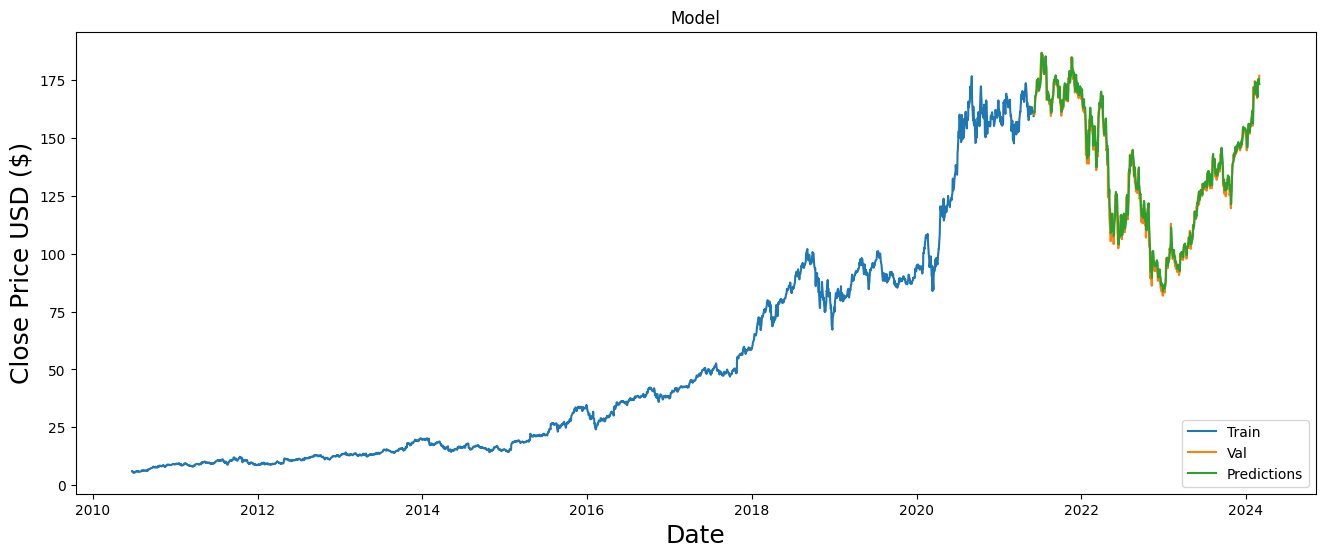

In [8]:
train = df[:df_length].copy()
valid = df[df_length:].copy()
valid['Predictions'] = predictions
train = train.set_index('Date')
valid = valid.set_index('Date')

plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()